In [0]:
import numpy as np 
import pandas as pd

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import csv
from csv import reader
from csv import writer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The acronym of ARIMA stands for [1]:

AutoRegressive = the model takes advantage of the connection between a predefined number of lagged observations and the current one.

Integrated = differencing between raw observations (eg. subtracting observations at different time steps).

Moving Average = the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q). These are:

P — Auto regressive feature of the model

D — Differencing order

Q — Moving average feature of the model

In [0]:
df=pd.read_csv("/content/drive/My Drive/final_dataset.csv",)
df

,Unnamed: 0,date,Category,high,low,open,close,volume,adj_close,comp,wr,moving_avg,RSI,stoch
0,0,01-07-2015,Transportation,312.700012,306.500000,308.799988,311.299988,2854143,303.809296,Adani Ports & SEZ,-22.580994,311.299988,0.000000,77.419006
1,1,02-07-2015,Transportation,319.000000,311.899994,312.450012,316.049988,8669541,308.445007,Adani Ports & SEZ,-23.600098,313.674988,0.000000,76.399902
2,2,03-07-2015,Transportation,325.750000,319.000000,319.950012,320.799988,5189498,313.080688,Adani Ports & SEZ,-25.714349,316.049988,0.000000,74.285651
3,3,06-07-2015,Transportation,321.100006,316.250000,316.950012,320.100006,2853145,312.397553,Adani Ports & SEZ,-29.350618,317.062492,0.000000,70.649382
4,4,07-07-2015,Transportation,334.700012,321.600006,321.799988,333.049988,7877450,325.035919,Adani Ports & SEZ,-5.851148,320.259991,93.137435,94.148852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58695,58695,01-04-2020,Media & Entertainment,126.750000,120.000000,124.000000,120.900001,6571413,120.900001,ZEEL,-91.958041,141.136667,30.112364,8.263475
58696,58696,03-04-2020,Media & Entertainment,125.949997,119.050003,123.000000,124.349999,7887911,124.349999,ZEEL,-87.604792,136.716668,31.874355,14.577463
58697,58697,07-04-2020,Media & Entertainment,143.000000,126.650001,129.000000,140.899994,11487040,140.899994,ZEEL,-62.112685,133.923334,39.689528,37.887315
58698,58698,08-04-2020,Media & Entertainment,148.149994,135.250000,138.000000,143.149994,10046602,143.149994,ZEEL,-58.943671,132.376666,40.680751,41.056329


In [0]:
df['date'] = pd.to_datetime(df.date,format='%d-%m-%Y')

In [0]:
df=df[df['comp']=='Asian Paints']
df

,Unnamed: 0,date,Category,high,low,open,close,volume,adj_close,comp,wr,moving_avg,RSI,stoch
1174,1174,2015-07-01,Consumer Non Durables,765.599976,755.099976,757.450012,760.799988,1025215,733.908081,Asian Paints,-0.853180,280.906667,0.000000,99.146820
1175,1175,2015-07-02,Consumer Non Durables,772.500000,761.099976,763.099976,762.900024,973819,735.933899,Asian Paints,-1.685685,314.543335,0.000000,98.314315
1176,1176,2015-07-03,Consumer Non Durables,778.400024,758.400024,762.000000,772.700012,1068877,745.387512,Asian Paints,-0.990617,348.963336,0.000000,98.992575
1177,1177,2015-07-06,Consumer Non Durables,786.150024,762.000000,765.000000,783.549988,652931,755.853943,Asian Paints,-0.453323,387.346669,0.000000,99.538878
1178,1178,2015-07-07,Consumer Non Durables,827.900024,790.049988,793.000000,824.599976,2464459,795.452881,Asian Paints,-0.544922,426.870000,0.000000,99.443359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,2343,2020-04-01,Consumer Non Durables,1655.000000,1584.250000,1650.050049,1603.199951,1559455,1603.199951,Asian Paints,-61.226339,1648.039974,42.525059,41.691911
2344,2344,2020-04-03,Consumer Non Durables,1616.000000,1517.250000,1615.099976,1520.900024,2925847,1520.900024,Asian Paints,-78.257166,1626.543310,37.965648,25.731511
2345,2345,2020-04-07,Consumer Non Durables,1635.000000,1538.000000,1540.000000,1623.800049,2733586,1623.800049,Asian Paints,-44.750418,1614.949984,45.756591,55.249582
2346,2346,2020-04-08,Consumer Non Durables,1687.800049,1600.000000,1623.800049,1608.949951,2382213,1608.949951,Asian Paints,-49.010341,1609.986645,44.884954,54.299663


In [0]:
df.shape

(1174, 14)

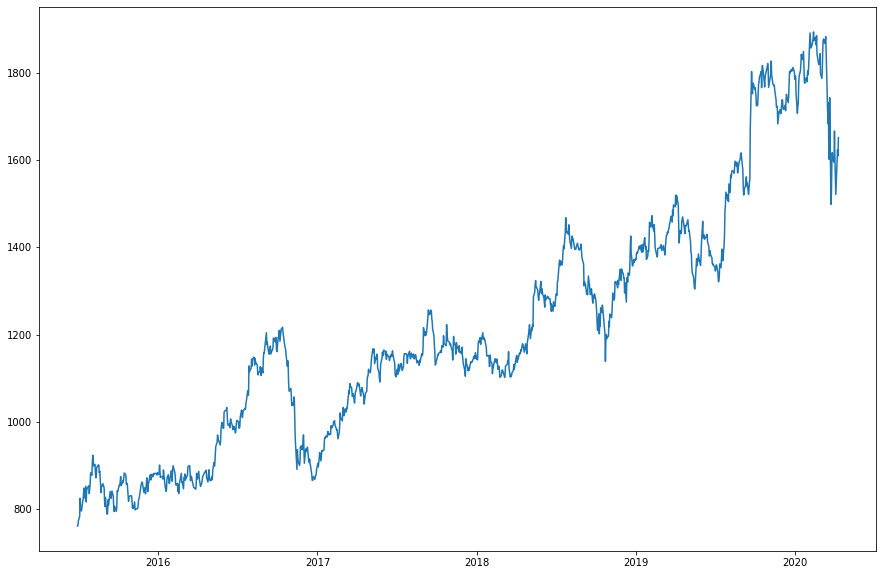

In [0]:
#plot
plt.plot(df['date'],df['close'], label='Close Price history')

In [0]:
# Get the Adjusted Close Price
df = df[['date','wr',	'moving_avg'	,'RSI',	'stoch','adj_close']]
#Take a look at the new data
print (df)

           date         wr   moving_avg        RSI      stoch    adj_close
1174 2015-07-01  -0.853180   280.906667   0.000000  99.146820   733.908081
1175 2015-07-02  -1.685685   314.543335   0.000000  98.314315   735.933899
1176 2015-07-03  -0.990617   348.963336   0.000000  98.992575   745.387512
1177 2015-07-06  -0.453323   387.346669   0.000000  99.538878   755.853943
1178 2015-07-07  -0.544922   426.870000   0.000000  99.443359   795.452881
...         ...        ...          ...        ...        ...          ...
2343 2020-04-01 -61.226339  1648.039974  42.525059  41.691911  1603.199951
2344 2020-04-03 -78.257166  1626.543310  37.965648  25.731511  1520.900024
2345 2020-04-07 -44.750418  1614.949984  45.756591  55.249582  1623.800049
2346 2020-04-08 -49.010341  1609.986645  44.884954  54.299663  1608.949951
2347 2020-04-09 -32.747836  1604.636645  47.919919  67.489263  1651.349976

[1174 rows x 6 columns]


In [0]:
df=df.dropna()

In [0]:
X=df[['wr',	'moving_avg'	,'RSI',	'stoch']]
y=df['adj_close']
y=np.asarray(y)

In [0]:
X_train=X[:int(0.8*len(X))]
X_train_date=df['date'][:int(0.8*len(X))]
X_test=X[int(0.8*len(X)):]
X_test_date=df['date'][int(0.8*len(X)):]
y_train=y[:int(0.8*len(y))]
y_test=y[int(0.8*len(y)):]

In [0]:
minn=np.min(X_train)
maxx=np.max(X_train)
X_train=(X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test=(X_test-minn)/(maxx-minn)

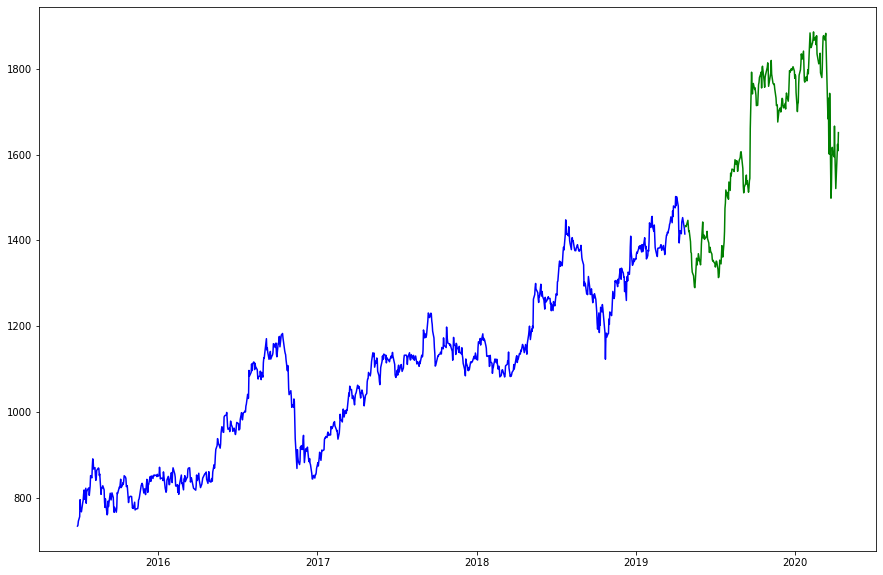

In [0]:
plt.plot(X_train_date,y_train, 'blue', label='Training Data')
plt.plot(X_test_date,y_test, 'green', label='Testing Data')

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. 

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

In [0]:
from sklearn.metrics import mean_squared_error

history =y_train
print(type(history))
predictions = np.array([])
for t in range(len(y_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions=np.append(predictions,yhat)
    obs = y_test[t]
    history=np.append(history,obs)
error = np.sqrt(np.mean(np.square(predictions-y_test)))
print('RMS error: ',error)

<class 'numpy.ndarray'>
RMS error:  33.95403170845315


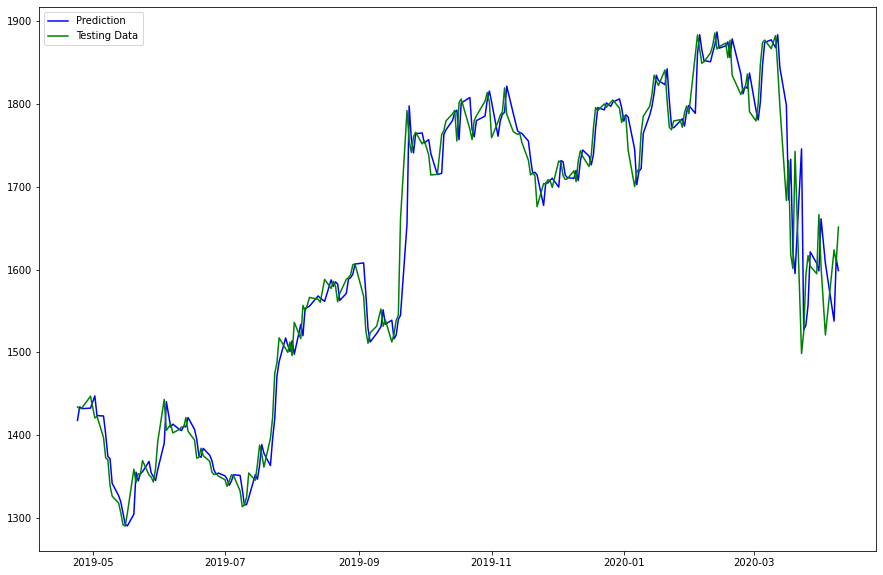

In [0]:
plt.plot(X_test_date,predictions, 'blue', label='Prediction')
plt.plot(X_test_date,y_test, 'green', label='Testing Data')
plt.legend()
plt.show()